In [1]:
%%capture
# ---------------------------------------------------------------------------- #
#                        DETAILS TECHNIQUES DU NOTEBOOK                        #
# ---------------------------------------------------------------------------- #

%load_ext autoreload
%autoreload 2

import sys
import os
from tqdm.notebook import tqdm_notebook

# Add src to path
sys.path.append(os.path.abspath(os.path.join('..', 'src', "pytorch")))

# Remove TensorFlow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Description

Ce notebook a vocation a être lu après avoir lu le notebook présentant notre travail avec la bibliothèque Tensorflow. En effet, si le premier notebook suivait un tutoriel en ligne, celui-ci présente une implémentation libre du papier [Attribution Axiomatique pour les réseaux profonds](https://arxiv.org/abs/1703.01365) dans la bibliothèque **PyTorch**, qui n'est pas la bibliothèque originale de l'article.

Afin de rester cohérent avec notre premier notebook, nous avons décidé de tester la méthode d'Attribution sur le même modèle que dans le premier Notebook : **Inception_V1**.

# Chargement du modèle

In [2]:
from Model import Model

model = Model().summary()

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

Using cache found in /home/lopilo24/.cache/torch/hub/pytorch_vision_v0.10.0
/home/lopilo24/Epita/Ing3/Epita-S9-DNN/.venv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/lopilo24/Epita/Ing3/Epita-S9-DNN/.venv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


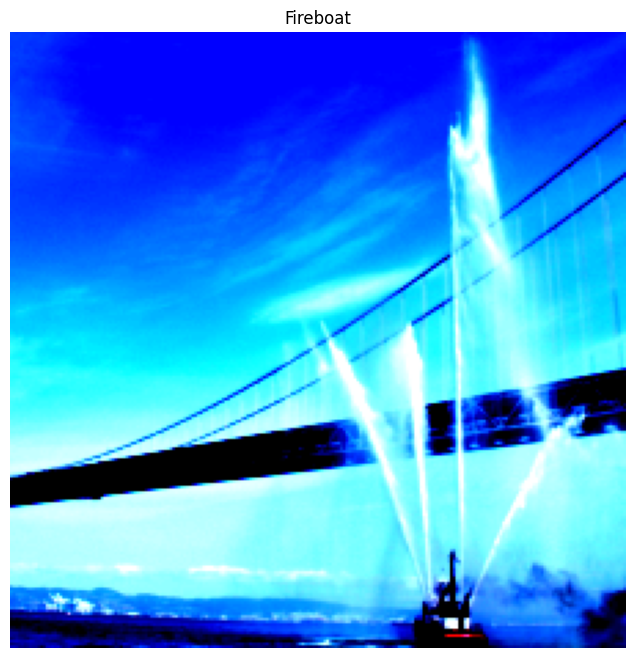

In [3]:
# ---------------------------------------------------------------------------- #
#                             CHARGEMENT DES IMAGES                            #
# ---------------------------------------------------------------------------- #

model = model.load_images({
    'Fireboat': 'http://storage.googleapis.com/download.tensorflow.org/example_images/San_Francisco_fireboat_showing_off.jpg',
}, display=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


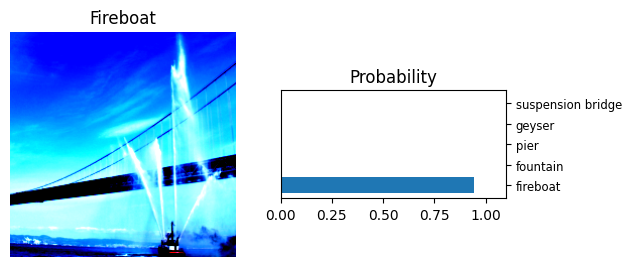

In [4]:
model.predict(display=True)

# Gradients Intégrés

> Contrairement au premier notebook où nous avons privilégié une approche compréhensive, étape par étape de la méthode, nous souhaitons ici implémenter une unique fonction optimisée pour un calcul de nombreuses attributions en parallèle avec une demande en mémoire nettement moindre (car nous ne conservons plus les étapes intermédiaires en mémoire).

Par ailleurs, après avoir lu cet excellentissime [article](https://distill.pub/2020/attribution-baselines/), nous avons décidé d'effectuer notre calcul final à partir d'une moyenne des attributions obtenues par $n$ Baselines aléatoires.

In [5]:
from IntegratedGradients import IntegratedGradients

integrator = IntegratedGradients(model=model, baseline_color="black")
integrator.compute_integrated_gradients(steps=50, number_of_trials=10)

  0%|          | 0/10 [00:00<?, ?it/s]

/home/lopilo24/Epita/Ing3/Epita-S9-DNN/src/pytorch/IntegratedGradients.py:256: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  obs_tensor = torch.tensor(


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


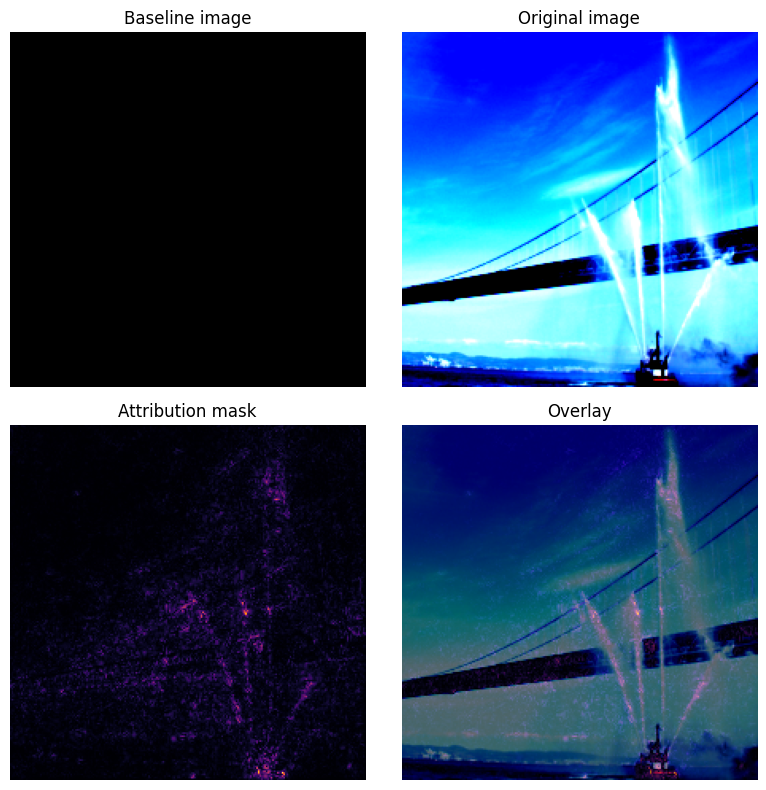

In [6]:
integrator.plot_integrated_gradients()

En conclusion, on observe que les résultats obtenus sont très proches de ceux obtenus avec la bibliothèque Tensorflow, ce qui est rassurant. Le meilleur prétraitement des entrées ainsi que la méthode consistant à moyenner les résultats pour différentes **Baselines** semble être une bonne idée : En effet, nos attributions se concentrent bien sur les parties les plus pertinente de l'image. Dans l'exemple ci-dessus, on note particulièrement que les **Gradients integrés** ont souligné les contours du bateau, qui avait été ignoré dans le premier notebook. Les cables du pont ont pour leur part été ignorés, ce qui est cohérent avec le fait que leur présence n'est pas pertinente pour la classification de l'image.

Pour comparaison avec la méthode implémentée dans le notebook *tensorflow.ipynb* utilisant une simple attribution avec une **Baseline** uniformément noire,

![](ressources/tensorflow_attribution.png)

On note bien que les attributions obtenues avec PyTorch sont plus précises, et que les résultats sont plus cohérents avec les résultats obtenus avec la méthode de Tensorflow. L'idée de moyenner les résultats pour différentes **Baselines** semble donc être une bonne idée.